# Fitting Models

**Learning Objectives:** learn to fit models to data using linear and non-linear regression.

This material was developed by Brian Granger, adapted from material from Jake VanderPlas and Jennifer Klay.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import optimize as opt

In [2]:
from ipywidgets import interact

## Introduction

In Data Science it is common to start with data and develop a *model* of that data. Such models can help to explain the data and make predictions about future observations. In fields like Physics, these models are often given in the form of differential equations, whose solutions explain and predict the data. In most other fields, such differential equations are not known. Often, models have to include sources of uncertainty and randomness. Given a set of data, *fitting* a model to the data is the process of tuning the parameters of the model to *best* explain the data.

When a model has a linear dependence on its parameters, such as $a x^2 + b x + c$, this process is known as *linear regression*.  When a model has a non-linear dependence on its parameters, such as $ a e^{bx} $, this process in known as non-linear regression. Thus, fitting data to a straight line model of $m x + b $ is linear regression, because of its linear dependence on $m$ and $b$ (rather than $x$).

## Fitting a straight line

A classical example of fitting a model is finding the slope and intercept of a straight line that goes through a set of data points $\{x_i,y_i\}$. For a straight line the model is:

$$
y_{model}(x) = mx + b
$$

Given this model, we can define a metric, or *cost function*, that quantifies the error the model makes. One commonly used metric is the [mean-squared error]() or MSE, which depends on the deviation of the model from each data point ($y_i - y_{model}(x_i)$).

$$
MSE = \frac{1}{N-2} \sum_{i=1}^N \left( y_i - y_{model}(x) \right)^2
$$

When the MSE is small, the model's predictions will be close the data points. Likewise, when the MSE is large, the model's predictions will be far from the data points. Given this, our task is to minimize the MSE with respect to the model parameters $\theta = [m, b]$ in order to find the best fit.

The factor $N-2$ is called the *degrees of freedom* and is equal to the number of data points minus the number of model parameters.

To illustrate linear regression, let's create a synthetic data set with a known slope and intercept, but random noise that is additive and normally distributed.

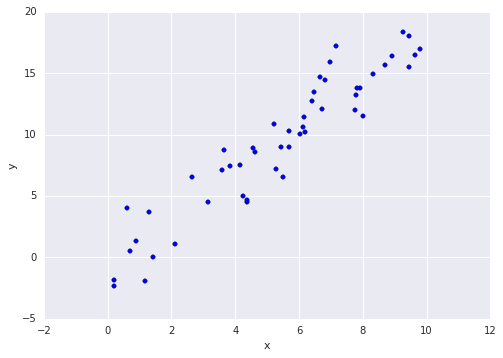

In [3]:
N = 50
m_true = 2
b_true = -1
dy = 2.0 # uncertainty of each point

np.random.seed(0)
xdata = 10 * np.random.random(N) # don't use regularly spaced data
ydata = b_true + m_true * xdata + np.random.normal(0.0, dy, size=N) # our errors are additive

plt.scatter(xdata, ydata)
plt.xlabel('x')
plt.ylabel('y');

### Fitting by hand

It is useful to see visually how changing the model parameters changes the MSE. By using IPython's `interact` function, we can create a user interface that allows us to pick a slope and intercept interactively and see the resulting line and $\chi^2$ value.

Here is the function we want to minimize. Note how we have combined the two parameters into a single parameters vector $\theta = [m, b]$, which is the first argument of the function:

In [4]:
def mse(theta, x, y):
    b = theta[0]
    m = theta[1]
    return np.sum((y - b - m*x) ** 2)/(len(x)-2)

In [5]:
def manual_fit(b, m):
    modely = m*xdata + b
    plt.plot(xdata, modely)
    plt.scatter(xdata, ydata)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(-2,12)
    plt.ylim(-5,20)
    plt.text(1, 15, 'b={0:.2f}'.format(b))
    plt.text(1, 12.5, 'm={0:.2f}'.format(m))
    plt.text(1, 10.0, '$MSE$={0:.2f}'.format(mse([b,m],xdata,ydata)))

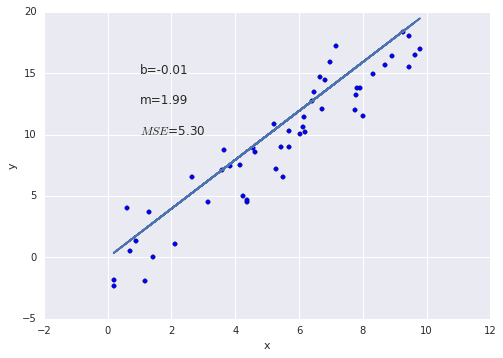

In [6]:
interact(manual_fit, b=(-3.0,3.0,0.01), m=(0.0,4.0,0.01));

Go ahead and play with the sliders and try to:

* Find the lowest value of the MSE.
* Find the "best" line through the data points.

You should see that these two conditions coincide.

### Minimize the MSE using `scipy.optimize.minimize`

Now that we have seen how minimizing the MSE gives the best parameters in a model, let's perform this minimization numerically using `scipy.optimize.minimize`. We have already defined the function we want to minimize, `mse`, so we only have to pass it to `minimize` along with an initial guess and the additional arguments (the raw data):

In [7]:
theta_guess = [0.0,1.0]
result = opt.minimize(mse, theta_guess, args=(xdata,ydata))
result

      jac: array([  5.96046448e-08,  -2.98023224e-08])
   status: 0
      fun: 3.5646982028358
  message: 'Optimization terminated successfully.'
  success: True
      nit: 3
     njev: 5
        x: array([-1.01441986,  1.93854654])
     nfev: 20
 hess_inv: array([[ 2.35397216, -0.34834456],
       [-0.34834456,  0.06475226]])

Here are the values of $b$ and $m$ that minimize $\chi^2$:

In [8]:
theta_best = result.x
print(theta_best)

[-1.01441986  1.93854654]


These values are close to the true values of $b=-1$ and $m=2$. The reason our values are different is that our data set has a limited number of points. In general, we expect that as the number of points in our data set increases, the model parameters will converge to the true values. But having a limited number of data points is not a problem - it is a reality of most data collection processes.

We can plot the raw data and the best fit line:

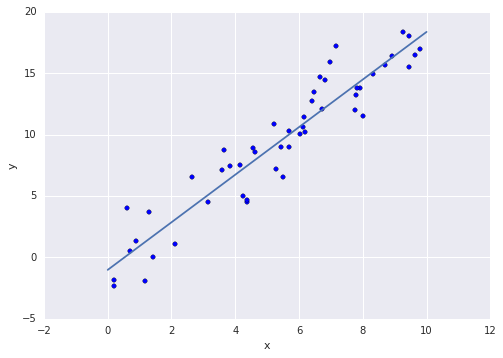

In [9]:
xfit = np.linspace(0,10.0)
yfit = theta_best[1]*xfit + theta_best[0]

plt.plot(xfit, yfit)
plt.scatter(xdata, ydata)
plt.xlabel('x')
plt.ylabel('y');

### Minimize the MSE using `scipy.optimize.leastsq`

Performing regression by minimizing the MSE is known as *least squares* regression, because we are minimizing the sum of squares of the deviations. The linear version of this is known as *linear least squares*. For this case, SciPy provides a purpose built function, `scipy.optimize.leastsq`. Instead of taking the MSE function to minimize, `leastsq` takes a function that computes the deviations:

In [10]:
def deviations(theta, x, y):
    return y - theta[0] - theta[1] * x

result = opt.leastsq(deviations, theta_guess, args=(xdata, ydata), full_output=True)

Here we have passed the `full_output=True` option. When this is passed the [covariance matrix](http://en.wikipedia.org/wiki/Covariance_matrix) $\Sigma_{ij}$ of the model parameters is also returned. The uncertainties (as standard deviations) in the parameters are the square roots of the diagonal elements of the covariance matrix:

$$ \sigma_i = \sqrt{\Sigma_{ii}} $$

A proof of this is beyond the scope of the current notebook.

In [11]:
theta_best = result[0]
theta_cov = result[1]
print('b = {0:.3f} +/- {1:.3f}'.format(theta_best[0], np.sqrt(theta_cov[0,0])))
print('m = {0:.3f} +/- {1:.3f}'.format(theta_best[1], np.sqrt(theta_cov[1,1])))

b = -1.014 +/- 0.313
m = 1.939 +/- 0.052


We can again plot the raw data and best fit line:

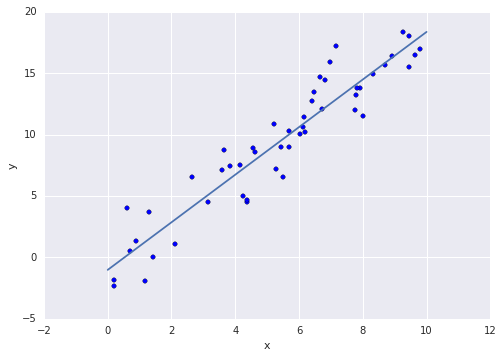

In [12]:
yfit = theta_best[0] + theta_best[1] * xfit

plt.scatter(xdata, ydata)
plt.plot(xfit, yfit)
plt.xlabel('x')
plt.ylabel('y');

### Fitting using `scipy.optimize.curve_fit`

SciPy also provides a general curve fitting function, `curve_fit`, that can handle both linear and non-linear models. This function: 

* Allows you to directly specify the model as a function, rather than the cost function (it assumes the MSE).
* Returns the covariance matrix for the parameters that provides estimates of the errors in each of the parameters.

Let's apply `curve_fit` to the above data. First we define a model function. The first argument should be the independent variable of the model.

In [13]:
def model(x, b, m):
    return m*x+b

Then call `curve_fit` passing the model function and the raw data. The uncertainties of each data point are provided with the `sigma` keyword argument. If there are no uncertainties, this can be omitted. By default the uncertainties are treated as relative. To treat them as absolute, pass the `absolute_sigma=True` argument.

In [14]:
theta_best, theta_cov = opt.curve_fit(model, xdata, ydata)

Again, display the optimal values of $b$ and $m$ along with their uncertainties:

In [15]:
print('b = {0:.3f} +/- {1:.3f}'.format(theta_best[0], np.sqrt(theta_cov[0,0])))
print('m = {0:.3f} +/- {1:.3f}'.format(theta_best[1], np.sqrt(theta_cov[1,1])))

b = -1.014 +/- 0.591
m = 1.939 +/- 0.098


We can again plot the raw data and best fit line:

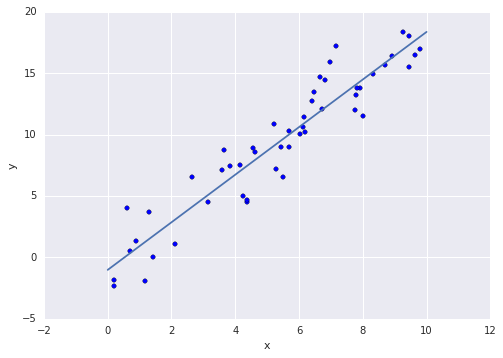

In [16]:
xfit = np.linspace(0,10.0)
yfit = theta_best[1]*xfit + theta_best[0]

plt.plot(xfit, yfit)
plt.scatter(xdata, ydata)
plt.xlabel('x')
plt.ylabel('y');

## Non-linear models

So far we have been using a linear model $y_{model}(x) = m x +b$. Remember this model was linear, not because of its dependence on $x$, but on $b$ and $m$. A non-linear model will have a non-linear dependece on the model parameters. Examples are $A e^{B x}$, $A \cos{B x}$, etc. In this section we will generate data for the following non-linear model:

$$y_{model}(x) = Ae^{Bx}$$

and fit that data using `curve_fit`. Let's start out by using this model to generate a data set to use for our fitting:

In [17]:
npoints = 20
Atrue = 10.0
Btrue = -0.2
tdata = np.linspace(0.0, 20.0, npoints)
dy = np.random.normal(0.0, 0.1, size=npoints)
ytdata = Atrue*np.exp(Btrue*tdata) + dy

Plot the raw data:

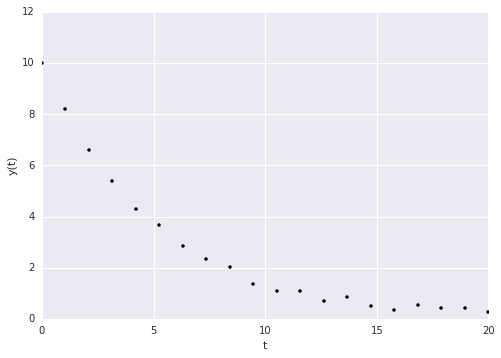

In [18]:
plt.plot(tdata, ytdata, 'k.')
plt.xlabel('t')
plt.ylabel('y(t)');

Let's see if we can use non-linear regression to recover the true values of our model parameters. First define the model:

In [19]:
def exp_model(x, A, B):
    return A*np.exp(x*B)

Then use `curve_fit` to fit the model:

In [20]:
theta_best, theta_cov = opt.curve_fit(exp_model, tdata, ytdata)

Our optimized parameters are close to the true values of $A=10$ and $B=-0.2$:

In [21]:
print('A = {0:.3f} +/- {1:.3f}'.format(theta_best[0], np.sqrt(theta_cov[0,0])))
print('B = {0:.3f} +/- {1:.3f}'.format(theta_best[1], np.sqrt(theta_cov[1,1])))

A = 10.036 +/- 0.089
B = -0.197 +/- 0.003


Plot the raw data and fitted model:

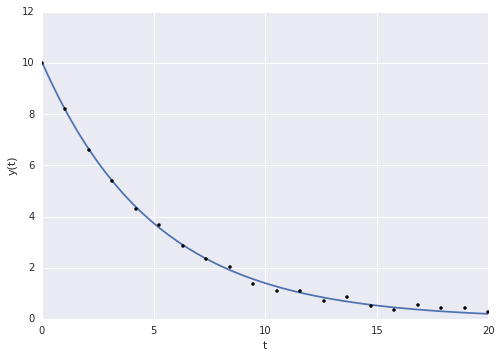

In [22]:
xfit = np.linspace(0,20)
yfit = exp_model(xfit, theta_best[0], theta_best[1])
plt.plot(xfit, yfit)
plt.plot(tdata, ytdata, 'k.')
plt.xlabel('t')
plt.ylabel('y(t)');

### A note about transforming to a linear model

Another approach to dealing with non-linear models is to linearize them with a transformation. For example, the exponential model used above,

$$y_{model}(x) = Ae^{Bx},$$

can be linearized by taking the natural log of both sides:

$$ ln(y) = ln(A) + B x $$

This model is linear in the parameters $ln(A)$ and $B$ and can be treated as a standard linear regression problem. This approach is used in most introductory physics laboratories. **However, in most cases, transforming to a linear model will give a poor fit. The reasons for this are a bit subtle, but here is the basic idea:

* Least squares regression assumes that errors are symmetric, additive and normally distributed. This assumption has been present throughout this notebook, when we generated data by *adding* a small amount of randomness to our data using `np.random.normal`.
* Transforming the data with a non-linear transformation, such as the square root, exponential or logarithm will not lead to errors that follow this assumption.
* However, in the rare case that there are no (minimal) random errors in the original data set, the transformation approach will give the same result as the non-linear regression on the original model.

Here is a [nice discussion](http://www.mathworks.com/help/stats/examples/pitfalls-in-fitting-nonlinear-models-by-transforming-to-linearity.html) of this in the Matlab documentation.

## Model selection

In all of the examples in this notebook, we started with a model and used that model to generate data. This was done to make it easy to check the predicted model parameters with the true values used to create the data set. However, in the real world, you almost never know the model underlying the data. Because of this, there is an additional step called *model selection* where you have to figure out a way to pick a good model. This is a notoriously difficult problem, especially when the randomness in the data is large.

* Pick the simplest possible model. In general picking a more complex model will give a better fit. However, it won't be a useful model and will make poor predictions about future data. This is known as [overfitting](http://en.wikipedia.org/wiki/Overfitting).
* Whenever possible, pick a model that has a underlying theoretical foundation or motivation. For example, in Physics, most of our models come from well tested differential equations.
* There are more advanced methods (AIC,BIC) that can assist in this model selection process. A good discussion can be found in [this notebook](https://github.com/jakevdp/2014_fall_ASTR599/blob/master/notebooks/14_Optimization.ipynb) by Jake VanderPlas.